# Data Model Evaluation with SHAP Values No Lags
* In the presented notebook we will try to get more insights and understand what our model is doing. Check the importance of features, its sign and its effect on our target variable Rreproduction rate.
* This evaluation analysis of shap values will work **without the lagged variable reproduction rate of week n-2**.
* This evaluation analysis of shap values will work **with mobility indexes**.

## Import Libraries

In [38]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
import shap
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pickle

## Authenticate to Google Drive 
(Request access to lucasbotellaroca@gmail.com if not conceded)

In [39]:
# A browser window will open. Login using the appropriate account.
gauth = GoogleAuth()
gauth.LocalWebserverAuth() #

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=267819126046-3da5rmgml4iemor49ermcv23tnaj02t5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [40]:
drive = GoogleDrive(gauth)

In [41]:
drive

## Auxiliary Functions

In [42]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(reg2_gbr)
    shap_values_Model = explainerModel.shap_values(X_train)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_train.iloc[[j]])
    return(p)

In [43]:
def read_csv_file(folder, fileName, nrows):
    
    read_file = drive.ListFile({'q': "title contains '" + fileName + ".csv' and '" + folder + "' in parents"}).GetList()
    
    if len(read_file)>0:
        title = read_file[0]['title']
        id = read_file[0]['id']
        each_file = drive.CreateFile({'id': id})
        each_file.GetContentFile(title)
        df = pd.read_csv(title, skiprows=nrows)
    else:
        
        df=pd.DataFrame()
    
    return df

## Read File and Prepare Data

* Same transofrmation as in the data model notebook is performed. 

In [44]:
#df=pd.read_csv('../df_covid_processed_final_reproduction_rate.csv')
df=read_csv_file('1kNVBQTd_m6OihGl5zXfkcbin9BtKzFEw','df_covid_processed_final_reproduction_rate',0)

#Selected columns for our analysis
df=df[['Code', 'Date', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'contact_tracing', 
       'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', 'youth_unemployment','infections_value',
      'accumulated', 'reproduction_rate']]

df = df[df['infections_value'].notna()]
df = df[df['accumulated'].notna()]
df['total_vaccinations_per_100'] = df['total_vaccinations_per_100'].fillna(0)
df['infections_value'][df['infections_value'] < 0] = 0

# Grouping data over 2 week intervals in order to increment the variability and response of our features on the target variable.
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby(['Code', pd.Grouper(key='Date', freq='2W-SUN')]).mean().reset_index()
df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Code,Date,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,income_support,...,holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,youth_unemployment,infections_value,accumulated,reproduction_rate
0,AUS,2020-03-22,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,0.0,...,0.0,21.346512,0.142010,8263000.0,85.904,0.000000,11.84,7.280,0.002502,2.170000
1,AUS,2020-04-05,-5.744929,18.591786,2.775500,-11.449000,-9.897929,3.020357,0.142857,1.0,...,0.0,20.939890,0.053343,8263000.0,85.904,0.000000,11.84,11.720,0.003440,2.305000
2,AUS,2020-04-19,-36.540929,-6.183786,15.520286,-54.489857,-33.755143,-29.040786,2.000000,1.0,...,0.0,19.987036,0.095946,8263000.0,85.904,0.000000,11.84,4.655,0.005606,1.111429
3,AUS,2020-05-03,-42.632571,-13.734857,19.632571,-62.428643,-35.979571,-44.683643,2.000000,1.0,...,1.0,19.008360,0.046547,8263000.0,85.904,0.000000,11.84,4.465,0.007019,0.432857
4,AUS,2020-05-17,-38.224500,-9.806071,16.112214,-56.928643,-32.959286,-34.867286,2.000000,1.0,...,0.5,16.998547,0.082838,8263000.0,85.904,0.000000,11.84,1.320,0.008205,0.589286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,USA,2021-01-10,-20.234643,-4.020429,11.418500,-37.459286,-18.204143,-35.091786,1.000000,2.0,...,0.5,2.296861,0.059487,75608000.0,82.058,0.451667,8.30,42.945,0.184976,0.977857
1233,USA,2021-01-24,-23.806214,-10.612286,12.755214,-40.295857,-19.224429,-35.357000,1.000000,2.0,...,0.5,1.849448,0.066435,75608000.0,82.058,1.939500,8.30,34.260,0.205035,1.070000
1234,USA,2021-02-07,-25.255071,-13.499929,10.765071,-40.734714,-20.091929,-28.816214,1.000000,2.0,...,0.5,2.291674,0.043928,75608000.0,82.058,5.282857,8.30,26.560,0.220400,0.870714
1235,USA,2021-02-21,-25.214286,-13.438786,10.428429,-41.153000,-24.530714,-27.714214,1.000000,2.0,...,0.0,-0.303134,0.044132,75608000.0,82.058,10.600000,8.30,14.225,0.230417,0.802857


In [45]:
df_appch2=df.copy()
df_appch2['mobility_index']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.4
                           +df_appch2['grocery_and_pharmacy']*0.1+df_appch2['workplaces']*0.1)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_closures_measures']=0.3*df_appch2['stay_home_requirements']\
                                + 0.3*df_appch2['restriction_gatherings']\
                                + 0.2*df_appch2['restrictions_internal_movements']\
                                + 0.1*df_appch2['international_travel_controls']\
                                + 0.1*df_appch2['close_public_transport']\
                                + 0.2*df_appch2['cancel_public_events']\
                                + 0.4*df_appch2['workplace_closures']\
                                + 0.4*df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','mobility_index', 'residential',
                     'awareness_measures', 'health_measures',
                     'mobility_closures_measures', 'economic_measures',
                     'holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                     'total_vaccinations_per_100', 'youth_unemployment',
                     'infections_value', 'accumulated', 'reproduction_rate']]

* Split referring last fold of our model evaluation.

In [46]:
df_time=df_appch2.sort_values('Date')
X=df_time[df_time.columns[2:-1]]
y=df_time[df_time.columns[-1]]
X_train, X_test = X.iloc[0:1148], X.iloc[1148:1237]   
y_train, y_test = y.iloc[0:1148], y.iloc[1148:1237]

## Import Models and Evaluate Shap Values
We will perform evaluation and analysis of the impact of variables on the training set predictions (year 2020).

In [47]:
pickle_file='../models/model_lgbm_reg'
reg2_gbr = pickle.load(open(pickle_file,'rb'))

### Tree explainer Bar Plot
We will plot our feature importance bar plot, this will represent the importance of each feature in terms of predictions of our target variable reproduction_rate

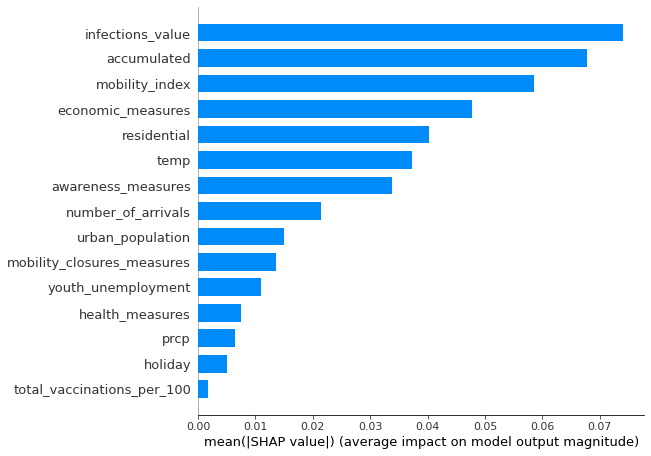

In [48]:
shap_values = shap.TreeExplainer(reg2_gbr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [49]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
13,infections_value,0.074062
14,accumulated,0.067757
0,mobility_index,0.058571
5,economic_measures,0.047789
1,residential,0.040156
7,temp,0.037232
2,awareness_measures,0.033815
9,number_of_arrivals,0.021499
10,urban_population,0.014924
4,mobility_closures_measures,0.013593


* As seen variables that seem to have a higher impact on our target variable reproduction rate are:
    * **infectious_value** which represents the amount of current people infecting
    * **accumulated** which represents the amount of people that have already contracted the virus
    * **mobility_index** which represents the mobility increase or decrease in reatil and recreation, transit stations, groceries, pharmacy and workplaces
    * **economic_measures** which represents the economic support given by governments in terms of debt relief and income support
    * **residential** which represents the amount of time people spend time at home
    * **temp** which represents the mean temperature presented in 2 week period
    * **awareness_measures** which represents government measures on facial coverings and public campaigns.
    * **number_of_arrivals** which represents the mobility of a country without covid (tourism)
    * **urban_population** which represents the precentage of population living in urban areas in a certain country

* Other variables that have smaller coefficients are **mobility and closure measures, awareness measures, youth unemployment, health measures, prpc, holiday or total_vaccinations_per_100**

## Generalization of shap values
* Code extracted from (https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

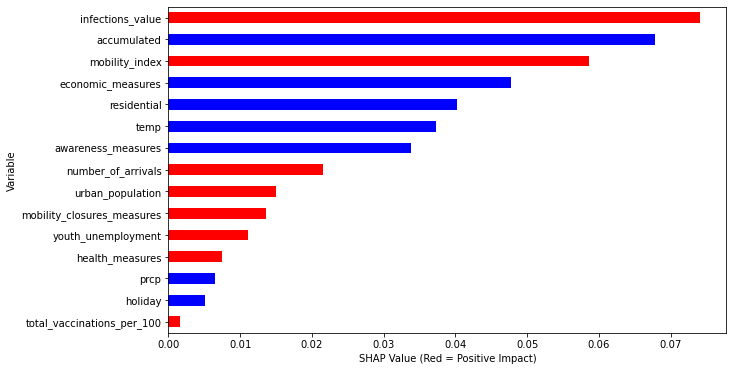

In [50]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

* In blue we can see variables that have negative sign or negative impact on the increase of reproduction rate and on red we can see variables that have positive sign or positive impact on our target variable.

* There some unexpected values such as health_measures and mobility_measures that seem to be positive for the virus, we will analyze those separetly.


### Tree explainer Plot

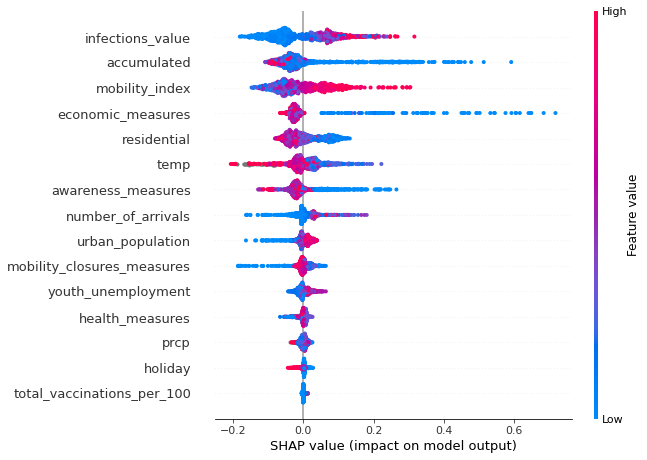

In [51]:
explainer = shap.TreeExplainer(reg2_gbr)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

We will perform a resume of the variables and its impact on our traget vairable **reproduction rate**

> **infections_value** which represents the amount of current people infecting.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **accumulated** which represents the amount of current people infecting.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **mobility_index** which represents the mobility increase or decrease in retail and recreation, transit stations, groceries, pharmacy and workplaces.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

> **economic_measures** which represents the economic support given by governments in terms of debt relief and income support.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.

> **residential** which represents the amount of time people spend time at home.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    
> **temp** which represents the average temperature in the deferred week.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
 
> **awareness_measures** which are variables that represent the conciency and awareness given from governments to the population, most meaningful one is "facial_coverings".
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    > However there are some very low values related with negative impact. Will analyze it more in detail later on.
    
> **urban_population** which is an indicator ot he percentage of people that live in urban areas and that tries to simulate population density.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    > However there are some very low values related with negative impact.
    
> **mobility_closure_measures** which are the restrictions in closings and mobility applied by governments.
    > * **High values** have **negative impact** on reproduction rate.
    > * **Low values** have **positive impact** on reproduction rate.
    > However there are some very low values related with negative impact. Will analyze it more in detail later on.

> **youth_unemployment** which is the percentage of youth unemployed in the referenced country.
    > * **High values** have positive impact on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.
    
> **number_of_arrivals** which is the usual number of tourists received but that represnets countries with high or small mobility worldwise.
    > * **High values** have **positive impact** on reproduction rate.
    > * **Low values** have **negative impact** on reproduction rate.

    
* The rest of the coefficients seem to have little influence in the target variable and the coeficients and importance of those variable may be absorved by some other variables previously mentioned. 

* health_measures and mobility_closure_measures seem to be getting confusing shap values,will analyze those in detaill taking usage of single variables dependence plots analysis.

However based on the grap it can be esimated that:

* **youth unemployment** is related with reproduction rate positively.
* **holiday** are related with reproduction rate positively on holidays with high values, however low values of holiday don´t seem to have impact on the response variable.


Some other variables may have such coefficients due to multicollinearity with other variables, based on the correlation matrix shown below. In order to detect this multicollinearity issues will analyze each of this features separately and its possible relation with some other more dominant features.

<AxesSubplot:>

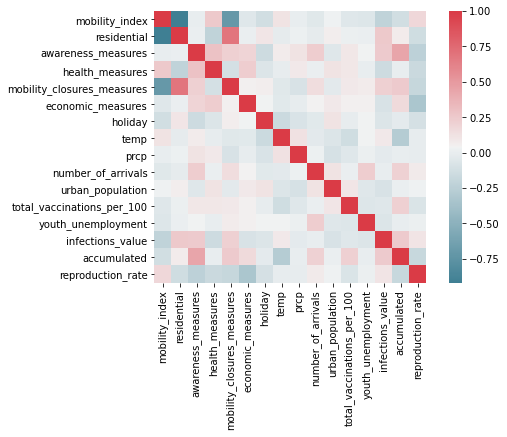

In [52]:
f, ax = plt.subplots(figsize=(8, 5))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [53]:
df_appch2.columns

Index(['Code', 'Date', 'mobility_index', 'residential', 'awareness_measures',
       'health_measures', 'mobility_closures_measures', 'economic_measures',
       'holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', 'youth_unemployment', 'infections_value',
       'accumulated', 'reproduction_rate'],
      dtype='object')

* Mobility index and residential are positive related with mobility measures and closure measures respectively, and inverse between themselves.

## Single Variables Dependence Plots Analysis

##### mobility_measures

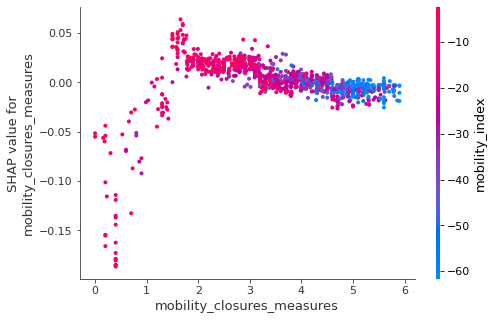

In [54]:
shap.dependence_plot("mobility_closures_measures", shap_values, X_train, interaction_index="mobility_index")

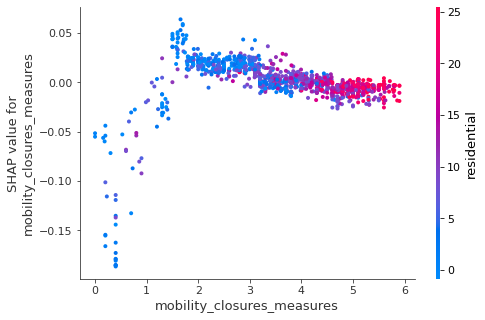

In [55]:
shap.dependence_plot("mobility_closures_measures", shap_values, X_train, interaction_index="residential")

* As seen mobility_measures have a relation with mobility index, therefore on the previous plots analyzed the impact of this variable is not really positive, it is just that **variable "mobility_index" has captured its effect** due to multicollinearity. This can be seen in the graph, low values of mobility_measures are related with high values in mobility_index which in fact affect the positive increase of reproduction rate. High values of mobility measures are related with low values of mobility_index and therefore negative impact on the response variable.


* It can also be seen how high values of mobility measures are related with high values in residential index, therefore, even though this variable is not being reflected as important in the shap analysis, it does have relation with two of the main features, mobility index and residential.


* The cause of this is **multicollinearity**, variable mobility index is capturing all the effect of this variable, as it can be seen as well in the correlation matrix.

##### health_measures

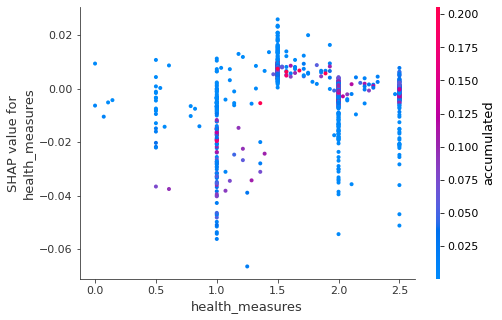

In [56]:
shap.dependence_plot("health_measures", shap_values, X_train)

<AxesSubplot:>

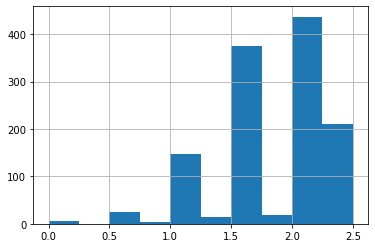

In [57]:
df_appch2.health_measures.hist()

* This variable doesn't seem to have relation with any other feature in the dataset. This variable reflects government  measures on testing and tracing cases. The referenced variable does not appear to have a big impact on the target variable, which is something confusing, however, no possible explanation has been found.

* However our target variable in the end is a very precise estimation taken from a reliable source as detailed in memory.pdf. And such variable is calculated in relation with number of positive cases among a lot other variablesand complex calculations, maybe an increasing number of testing and contact tracing is related in this case with the sign of the referenced variable.

##### total_vaccinations_per_100

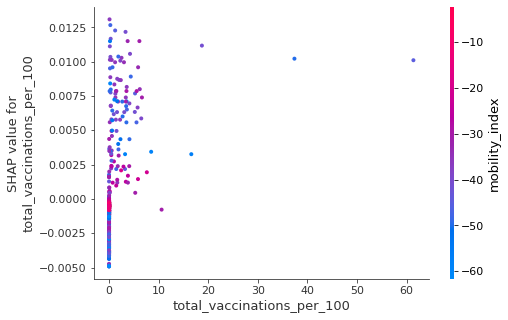

In [58]:
shap.dependence_plot("total_vaccinations_per_100", shap_values, X_train)

* This variable is of course predicticably the variable that should predict the most together with accumulated and infections, in fact it should have the same effect as accumulated, however since there is very few data collected for train of the model since vaccinations started in 2021 approximately, the model is not including it as an important feature, however in future analysis with more amount of data this variable will predictably have the same weight as accumulated.

##### prcp 

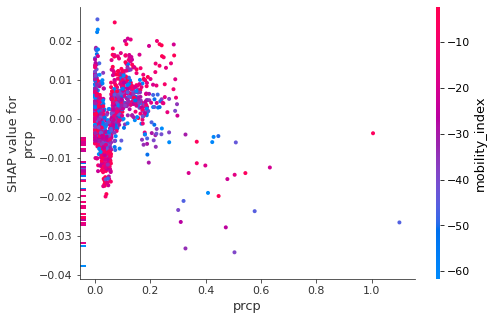

In [59]:
shap.dependence_plot("prcp", shap_values, X_train, interaction_index="mobility_index")

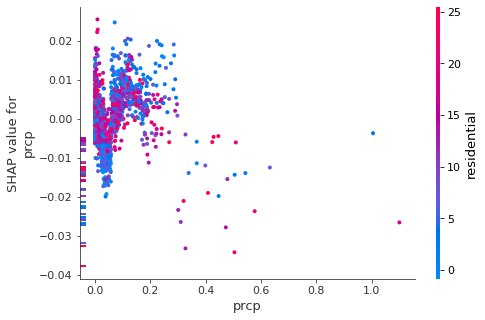

In [60]:
shap.dependence_plot("prcp", shap_values, X_train, interaction_index="residential")

* We can see that precipitations don't seem to have no relation with the mobility index netiher residential. However it does seem to have negative impact on the target variable base on tree explainer plot meaning, high values are related with low values of reproduction rate.

##### holiday 

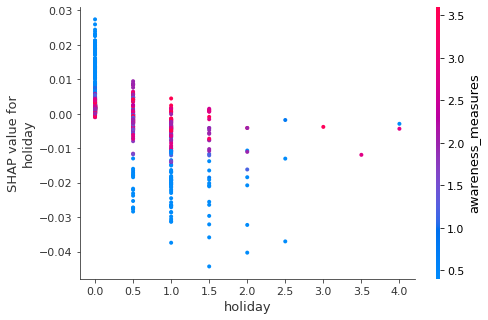

In [61]:
shap.dependence_plot("holiday", shap_values, X_train)

* We can see that holiday is mostly related with mobility index, however there doesn´t seem to be a relation between holiday and mobility_index, netiher with our target variable based on the tree plot analyzed before.

## Quick look over some predictions

In [62]:
#Real value
y_train.iloc[15]

2.716666666666667

In [63]:
#Estimation
shap.initjs()
shap_plot(0)

In [64]:
#Real value
y_train.iloc[20]

2.5064285714285717

In [65]:
#Estimation
shap.initjs()
shap_plot(20)

In [66]:
#Real value
y_train.iloc[500]

0.9821428571428572

In [67]:
#Estimation
shap.initjs()
shap_plot(500)

In [68]:
#Real value
y_train.iloc[750]

1.6549999999999998

In [69]:
#Estimation
shap.initjs()
shap_plot(750)

## Conclusion

* Overall the presented model as seen in [03_data_model_evaluation.ipynb](https://github.com/lucasbotellaroca/Covid-19_Reproduction_Rate_Estimator/blob/main/notebooks/03_data_model_evaluation.ipynb) as a forecast and predictive model does not seem to be very good, although mae and mape scores are relatively good in terms of deviation against the target variable it has been appreciated and detailed the issue of r2 score.


* From an explanatory point of view as seen in this notebook most features have signs and effects that do match with expertise knowledge. However there a re two features regarding restiction, mobility measures and health measures that do not have the expected behaviour, however as it has been assessed this is due to multicollinearity issues detailed. Vaccinations do not have an effect as it has also been detailed due to lack of data of vaccination period.